In [ ]:
import clip
from PIL import Image
import torch

model, preprocess = clip.load('ViT-B/16', device = f'cuda:{0}')


img = Image.open('test_image.png')
img = preprocess(img).unsqueeze(0).to(0)


In [ ]:
model.visual(torch.rand(1,3,224,224).to(0).to(torch.float16))

In [ ]:
model.encode_image(img).shape

In [ ]:
model.visual(img.to(torch.float16)).shape

In [ ]:
from torchsummary import summary

mod = model.visual.to(torch.float32)
mod.proj = None
summary(mod, (3,224,224));

In [ ]:

feats = []
def hook(module, input, output):
    feats.append(output)

# ids = [m[1].register_forward_hook(hook) for m in mod.named_modules()]

id = mod.transformer.register_forward_hook(hook)
_ = mod(torch.randn(2,3,224,224).to(0))
id.remove()
# for id in ids:
#     id.remove()

In [ ]:
out = feats[0]

out.transpose(0,1)[:,1:].transpose(1,2).reshape(2,768,14,14)

In [ ]:
import clip 
import torch

model, preprocess = clip.load('ViT-B/16', device = f'cuda:{0}')

outs = model.visual(torch.rand(1,3,224,224).to(0).to(torch.float16))

In [ ]:
model.visual.forward

In [ ]:
outs = model.visual.forward(torch.rand(1,3,224,224).to(0).to(torch.float16))
outs.shape

In [ ]:
model.encode_image(torch.rand(1,3,224,224).to(0).to(torch.float16)).shape

In [ ]:
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(0)
text.shape

In [ ]:
model.encode_text(clip.tokenize(["a diagram", "a dog", "a cat"]).to(0)).shape

In [ ]:
feats = []
feats.append(model.encode_image(torch.rand(1,3,224,224).to(0).to(torch.float16)))
feats.append(model.encode_text(clip.tokenize(["a diagram", "a dog", "a cat"]).to(0)))

### Seeing the forward function in Zegclip

In [ ]:
from models import CLIPViT
import torch
import math 

outs = CLIPViT().get_features(torch.rand(1,3,224,224).to(0).to(torch.float16),layers = [11])

In [ ]:
import torch

def d3_to_d4(t):
    n, hw, c = t.size()
    if hw % 2 != 0:
        t = t[:, 1:]
    h = w = int(math.sqrt(hw))
    return t.transpose(1, 2).reshape(n, c, h, w)

def d4_to_d3(t):
    return t.flatten(-2).transpose(-1, -2)

inputs_both = (outs, torch.rand(3,512).to(0))

In [ ]:
inputs = inputs_both[0][0]
cls_token = inputs_both[0][1]
text_token = inputs_both[1]

len(inputs), cls_token.shape, text_token.shape

In [ ]:
inputs[1].shape

In [ ]:
x = []
for stage_ in inputs[:1]:
    x.append(d4_to_d3(stage_) if stage_.dim() > 3 else stage_)
x.reverse()

In [ ]:
def get_qs(q, cls):
    # q = [q.cls, q]
    C, dim = q.shape
    bs, _ = cls.shape
    q = q.expand(bs, -1, -1)
    q1 = torch.einsum("bd,bcd->bcd", cls, q)
    q_ = torch.concat((q1, q), dim=-1)
    return q_

get_qs(text_token, cls_token).shape

In [ ]:
text_token.expand(1,-1,-1).shape

In [ ]:
outs[0][1].shape

In [ ]:
from models import SegDecoder
import torch 

inputs_both = [
    [(torch.rand(1,768,14,14).to(0),torch.rand(1,512,14,14).to(0)),torch.rand(1,512).to(0)],
    torch.rand(3,512).to(0)
]

decoder = SegDecoder(224,768,[0,1],[0,1]).to(0)

decoder(inputs_both)

In [ ]:
import clip
import torch

image_encoder = clip.load('RN50', device = f'cuda:{0}')[0].visual

In [ ]:
modules = dict(image_encoder.named_children())

In [ ]:
from models import CLIPResnet
import torch

feats = CLIPResnet().get_features(torch.rand(1,3,224,224).to(0))

In [ ]:
for f in feats:
    print(f.shape)

feats.reverse()

In [ ]:
from models import Decoder

decoder = Decoder(10).to(0).to(torch.float16)

decoder(feats).shape

In [ ]:
import clip

In [ ]:
from models import CLIPResNet, CLIPVisionTransformer
import torch 

model = CLIPResNet(
    layers=[3, 4, 6, 3],
    output_dim=1024,
    heads = 8,
    input_resolution=512
)



In [ ]:
outs = model.get_features(torch.rand(1,3,512,512))

for o in outs:
    print(o.shape)

In [ ]:
from models import CLIPVisionTransformer
import torch 

model = CLIPVisionTransformer(512,16,out_indices=[11,10])

In [ ]:
outs = model(torch.rand(1,3,512,512))

In [ ]:
import yaml

with open('trial_config.yaml', 'r') as f:
    file = yaml.safe_load(f)

file

In [ ]:
from data import cityscapes_dataset_train

img, target = cityscapes_dataset_train.__getitem__(10)

import matplotlib.pyplot as plt


plt.imshow(img.permute(1,2,0).numpy())
plt.show()
plt.imshow(target.permute(1,2,0).numpy())

In [97]:
import os 
from os.path import join
import pandas as pd

source = r'cityscapes_dataset'
folders = ['gtFine','leftImg8bit', 'leftImg8bit_foggy']
subset = 'val'

frames = []
for place_folder in os.listdir(join(source, folders[1], subset)):
    for file in os.listdir(join(source, folders[1], subset, place_folder)):
        place_name = place_folder
        image_number = '_'.join(file.split('_')[1:3])
        frames.append(pd.DataFrame(
            {
                'image': join(source, folders[1], subset, place_folder,file),
                'foggy_image': join(source, folders[2], subset, place_folder,f'{place_name}_{image_number}_leftImg8bit_foggy_beta_0.02.png'),
                'target':join(source, folders[0], subset, place_folder, f'{place_name}_{image_number}_gtFine_labelIds.png')
            },
            index=[0]
        ))

df = pd.concat(frames).reset_index(drop = True)

In [98]:
df.head()

,image,foggy_image,target
0,cityscapes_dataset/leftImg8bit/val/munster/mun...,cityscapes_dataset/leftImg8bit_foggy/val/munst...,cityscapes_dataset/gtFine/val/munster/munster_...
1,cityscapes_dataset/leftImg8bit/val/munster/mun...,cityscapes_dataset/leftImg8bit_foggy/val/munst...,cityscapes_dataset/gtFine/val/munster/munster_...
2,cityscapes_dataset/leftImg8bit/val/munster/mun...,cityscapes_dataset/leftImg8bit_foggy/val/munst...,cityscapes_dataset/gtFine/val/munster/munster_...
3,cityscapes_dataset/leftImg8bit/val/munster/mun...,cityscapes_dataset/leftImg8bit_foggy/val/munst...,cityscapes_dataset/gtFine/val/munster/munster_...
4,cityscapes_dataset/leftImg8bit/val/munster/mun...,cityscapes_dataset/leftImg8bit_foggy/val/munst...,cityscapes_dataset/gtFine/val/munster/munster_...


In [99]:
from PIL import Image

for i in range(len(df)):
    images = df.iloc[i]
    try:
        im = Image.open(images.image)
        im.verify()
        im.close()
    except:
        print(images.image)
    try:
        im = Image.open(images.foggy_image)
        im.verify()
        im.close()
    except:
        print(images.foggy_image)
    try:
        im = Image.open(images.target)
        im.verify()
        im.close()
    except:
        print(images.target)

In [100]:
df.to_csv(f'dataset/cityscape_{subset}.csv', index=False)

In [ ]:
from models import CLIPResNet, CLIPVisionTransformer
import yaml
import torch
args = yaml.safe_load(open('trial_config.yaml', 'r'))

resnet = CLIPResNet(
        layers = args['Resnet']['layers'],
        output_dim = args['Resnet']['output_dim'],
        heads = args['Resnet']['heads'],
        input_resolution = args['img_size'],
        width = args['Resnet']['width'],
        pretrained = args['Resnet']['pretrained']
    )

vit = CLIPVisionTransformer(
        input_resolution = args['img_size'],
        patch_size = args['VIT']['patch_size'],
        width = args['VIT']['width'],
        layers = args['VIT']['layers'],
        heads = args['VIT']['heads'],
        output_dim = args['VIT']['output_dim'],
        drop_path_rate = args['VIT']['drop_path_rate'],
        out_indices = args['VIT']['out_indices'],
        get_embeddings = args['VIT']['get_embeddings'],
        pretrained = args['VIT']['pretrained']
    )

In [ ]:
outs = resnet.get_features(torch.rand(1,3,512,512))
for o in outs:
    print(o.shape)

In [ ]:
vit_outs = vit(torch.rand(1,3,512,512))
vit_outs[0][0].shape, vit_outs[1].shape

#### Finding out the classes in the cityscapes dataset

In [ ]:
from data import dataset, labels
import torch
from matplotlib import pyplot as plt
import numpy as np

data = dataset('dataset/cityscape_train.csv', kaggle = False)

image, foggy, gt = data.__getitem__(0)


# gt = gt.permute(1,2,0)[:,:,:3]
# gt_255 = (gt*255).to(torch.int)
plt.imshow(image.permute(1,2,0))
# plt.imshow(gt)
# plt.show()
# plt.imshow(gt_255)

In [ ]:
for i in range(34):
    plt.imshow(gt[i])
    plt.show()

In [ ]:
x = torch.zeros(34,512,512)
error = 0
for i in range(512):
    for j in range(512):
        try:
            color = tuple(gt[i,j].numpy())
            id = color_mapping[color]
            x[id,i,j] = 255
        except:
            x[0,i,j] = 255

In [4]:
import torch
from torch import nn
import numpy as np

x1 = torch.randn(1,3,512,512).reshape(1,3,-1)
x2 = torch.randn(1,3,512,512).reshape(1,3,-1)


cos1 = nn.CosineSimilarity(dim=-1)
(1-cos1(x1,x2)).mean()

tensor(1.0009)

In [10]:
x1 = torch.randn(1,3,512,512)

x1.flatten(-2).shape

torch.Size([1, 3, 262144])

In [33]:
cos1(x1,x2).mean(),cos2(x1,x2).mean(),cos3(x1,x2).mean()

(tensor(-0.0008), tensor(-0.0009), tensor(-0.0002))

In [28]:
np.mean(cosine)

0.0012600875

In [48]:
from data import dataset, labels
import torch
from matplotlib import pyplot as plt
import numpy as np

data = dataset('dataset/cityscape_train.csv', image_size = 32, color_mapping = {label.color:label.id for label in labels}, kaggle = False)

image, foggy, gt = data.__getitem__(0)


In [60]:
nn.BCELoss()(gt,gt)

tensor(0.)

In [33]:
import torch
from torch import nn

label = torch.randint(low = 0, high = 2, size = (1,26,512,512))
pred = torch.randint(low = 0, high = 2, size = (1,26,512,512))

intersect = (pred & label).float().sum((2,3))
union = (pred | label).float().sum((2,3))
total_pixel_pred = pred.sum((2,3))
total_pixel_truth = label.sum((2,3))

(intersect/total_pixel_pred).mean()

tensor(0.5003)

In [36]:
intersect = (pred & label).float().sum((2,3))
sum = pred.sum((2,3)) + label.sum((2,3))
dice = 2*intersect/sum 
dice>intersect/union

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True]])

In [40]:
(torch.rand(1,26,512,512)>0.5).to(torch.float32)

tensor([[[[0., 0., 1.,  ..., 0., 1., 0.],
          [1., 0., 1.,  ..., 1., 1., 1.],
          [1., 1., 0.,  ..., 0., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [1., 1., 0.,  ..., 1., 1., 0.],
          [0., 1., 1.,  ..., 0., 1., 0.]],

         [[1., 1., 1.,  ..., 0., 1., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [0., 1., 0.,  ..., 1., 1., 0.],
          ...,
          [1., 0., 0.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 0.,  ..., 0., 0., 0.]],

         [[0., 1., 1.,  ..., 1., 0., 0.],
          [0., 1., 1.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 1.],
          ...,
          [0., 1., 0.,  ..., 1., 1., 0.],
          [0., 1., 1.,  ..., 1., 0., 0.],
          [0., 1., 1.,  ..., 1., 0., 1.]],

         ...,

         [[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 1., 1., 0.],
          [1., 0., 1.,  ..., 0., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 1., 

In [4]:
from data import dataset, labels
import torch
from matplotlib import pyplot as plt
import numpy as np

data = dataset('dataset/cityscape_train.csv', image_size = 512, num_classes =20, kaggle = False)

image, foggy, gt, mask = data.__getitem__(100)


# for i in range(20):
#     plt.imshow(gt[i])
#     plt.title(i)
#     plt.show()

gt.unique(), gt.shape, mask.unique(), mask.shape

(tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14.]),
 torch.Size([512, 512]),
 tensor([0., 1.], dtype=torch.float64),
 torch.Size([20, 512, 512]))

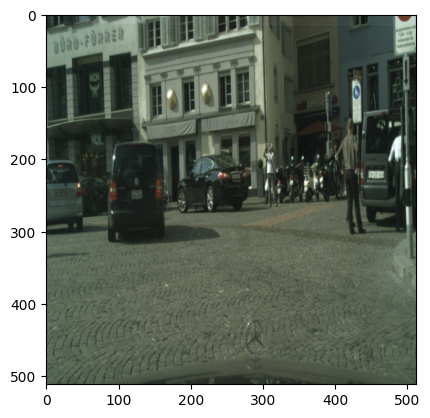

In [2]:
plt.imshow(image.permute(1,2,0))

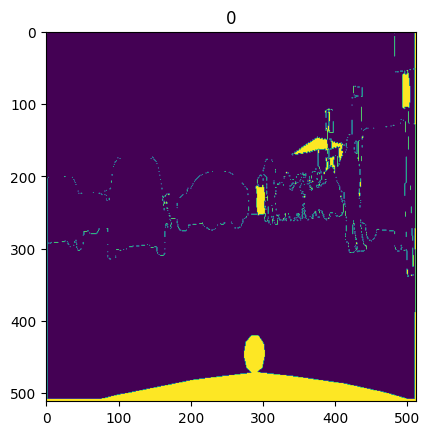

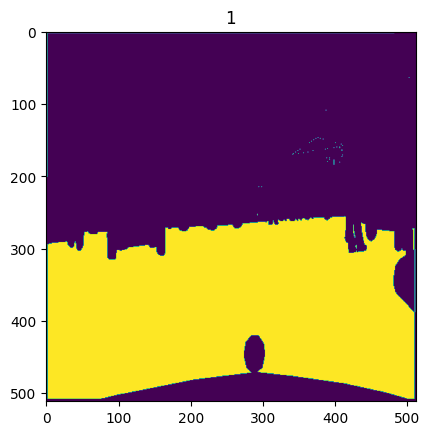

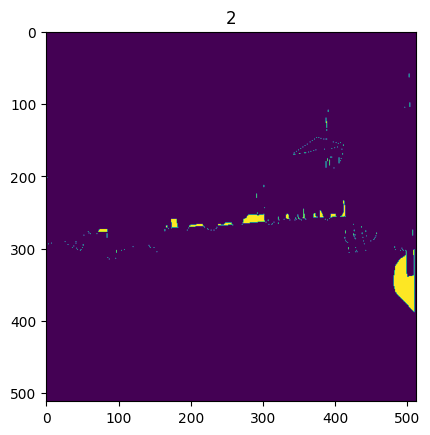

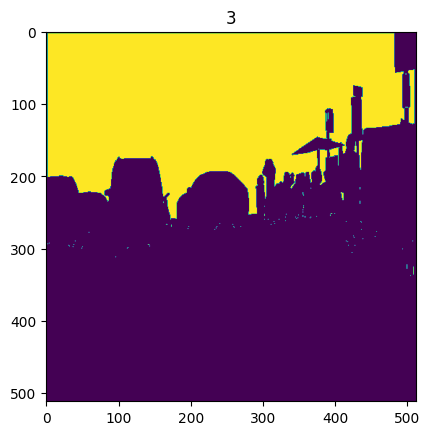

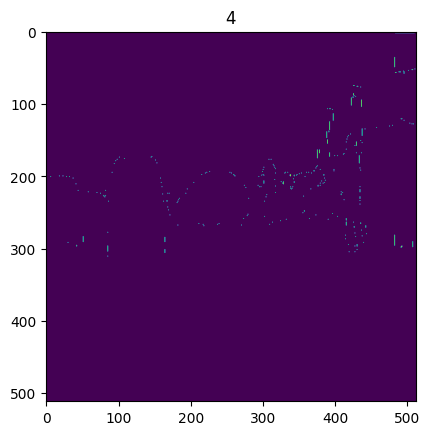

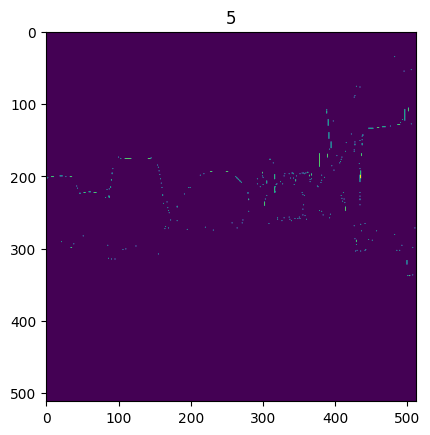

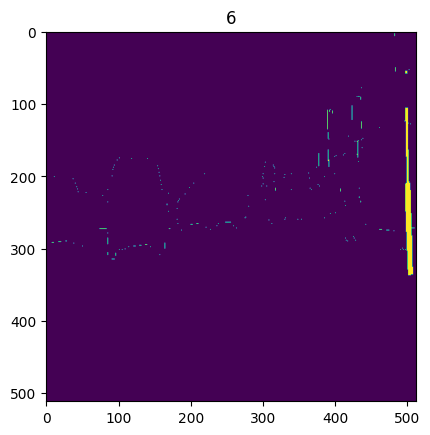

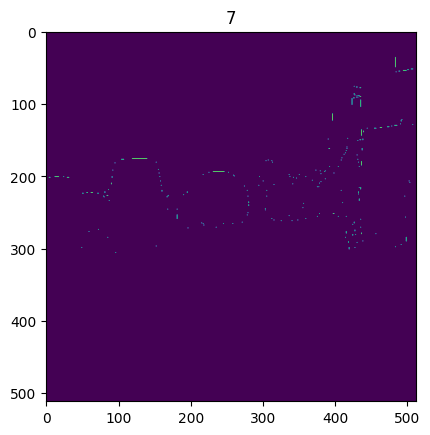

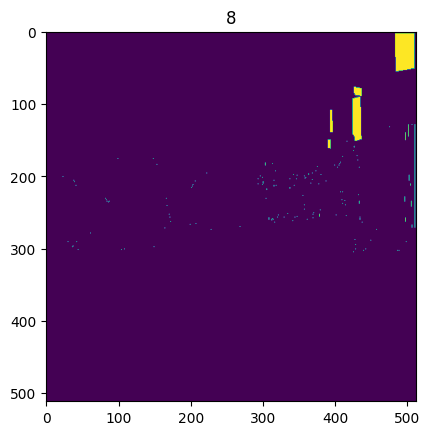

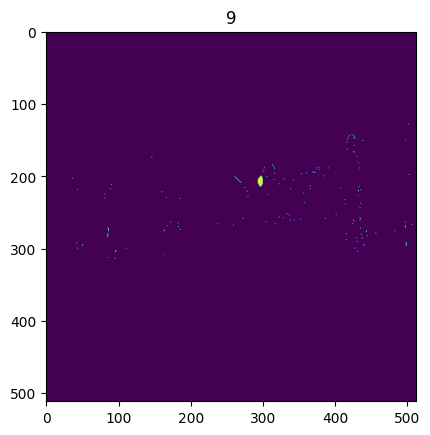

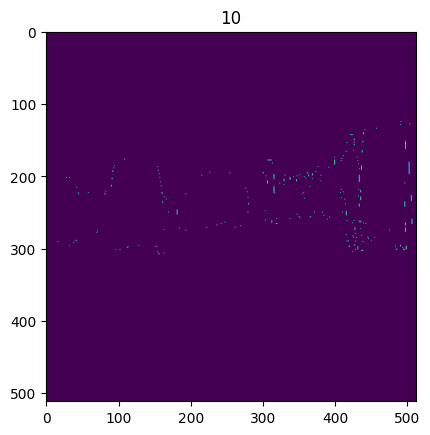

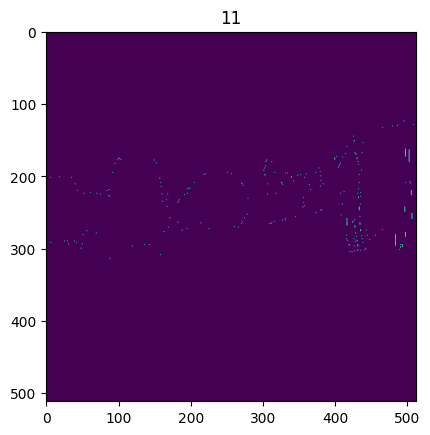

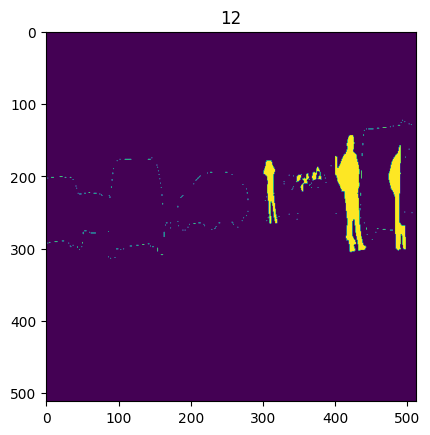

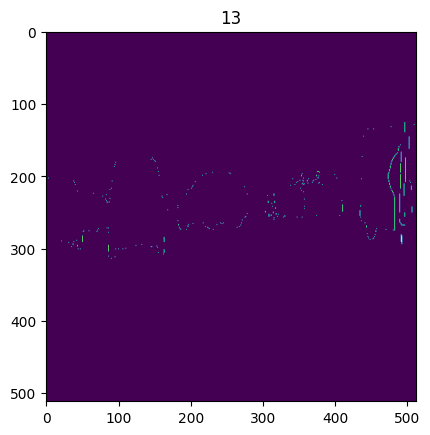

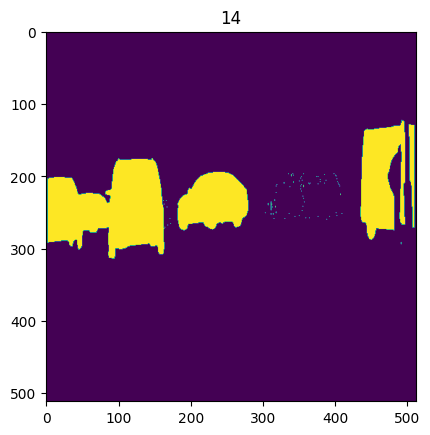

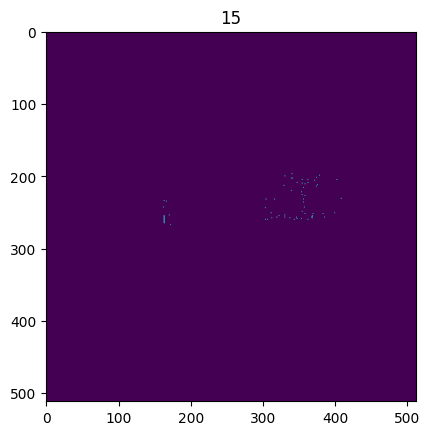

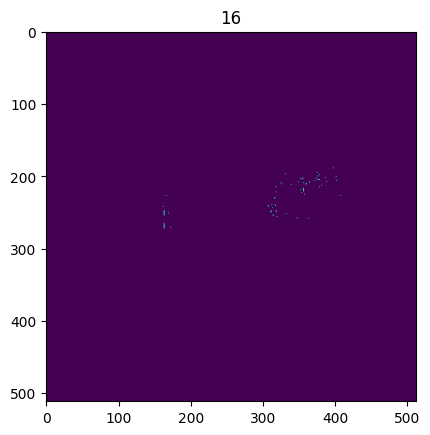

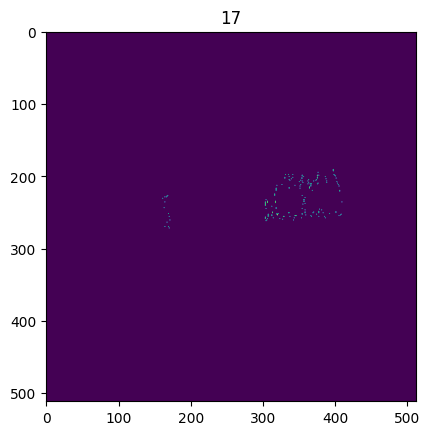

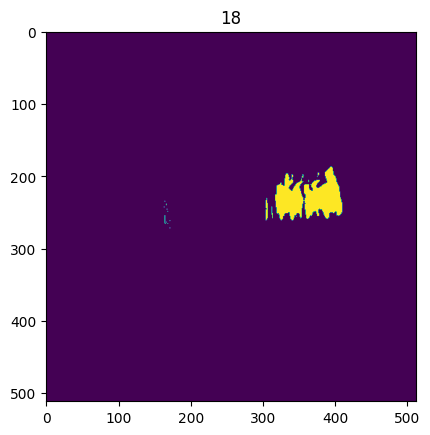

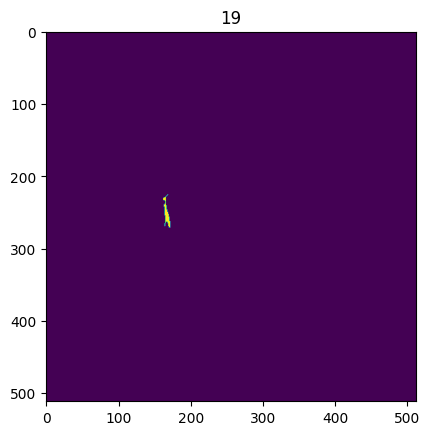

In [2]:
for i in range(20):
    plt.imshow(gt[i])
    plt.title(i)
    plt.show()

In [5]:
from data import labels
class_names = ['void']
for label in labels:
    if not label.id == 0 and not label.ignoreInEval:
        class_names.append(label.name)

In [5]:
from metrics import IoU

iou = IoU()

x1 = torch

iou(torch.randn(2,2,512,512), torch.randn(2,2,512,512))


tensor([0.5729, 0.3087, 0.3078, 0.1822])

In [8]:
input = torch.randn(2,2,512,512)
input.softmax(dim=1) == input

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, Fals

In [6]:
import torch

x = torch.rand(2,20,512,512)

x.softmax(dim=1).argmax(dim = 1).shape

torch.Size([2, 512, 512])